# Training / Gradient loop

In [ ]:
# Reproducibility.
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Instantiate model and optimizer
model = TBModel(num_hid_1 = 128, num_hid_2 = 128)
opt = torch.optim.Adam(model.parameters(),  learning_rate)

# Accumulate losses here and take a gradient step every `update_freq` episode (at the end of each trajectory).
losses, sampled_ics, sampled_expressions, logZs = [], [], [], []
minibatch_loss = torch.tensor([0], dtype=torch.float32)
update_freq = 20

n_episodes = 20000

alpha = AlphaGFN()

for episode in tqdm(range(n_episodes), ncols=100):
    
    alpha.reset()  # Each episode starts with an empty state and operand stack.
    P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))  # Forward and backward policy
    total_log_P_F, total_log_P_B = 0, 0

    for t in range(MAX_EXPR_LENGTH):  # All trajectories are at most length MAX_EXPR_LENGTH.

        # Here we mask the relevant forward actions.
        mask = alpha.get_forward_masks()
        P_F_s = torch.where(mask, P_F_s, -100)  # Removes invalid forward actions.

        # Here P_F is logits, so we use Categorical to compute a softmax.
        categorical = Categorical(logits=P_F_s)
        action = categorical.sample()  # Sample the next action.
        alpha.step(action)  # Update to new state.
        total_log_P_F += categorical.log_prob(action)  # Accumulate the log_P_F sum.

        # We recompute P_F and P_B for the new state.
        P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))
        mask = alpha.get_backward_masks()
        P_B_s = torch.where(mask, P_B_s, -100)  # Removes invalid backward actions.

        # Accumulate P_B, going backwards from new state. 
        total_log_P_B += Categorical(logits=P_B_s).log_prob(action)
        
        if alpha._action_to_token(action) == "SEP":  # End of trajectory.
            break

    if alpha._action_to_token(action) == "SEP":
        # We're done with the trajectory, let's compute its loss. Since the reward
        # can sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
        
        ic, log_reward = compute_log_reward(alpha.stack[0])
        if not np.isnan(log_reward):
            minibatch_loss += trajectory_balance_loss(
                model.logZ,
                total_log_P_F,
                total_log_P_B,
                log_reward = torch.tensor(log_reward, dtype=torch.float32),
            )
            # We're done with the episode, add the face to the list, and if we are at an
            # update episode, take a gradient step.
            sampled_expressions.append([alpha._action_to_token(action) for action in alpha.state])
            sampled_ics.append(ic) ## Naming error, should be `sampled_ics`
        
    if episode > 0 and episode % update_freq == 0 and minibatch_loss != 0:
        losses.append(minibatch_loss.item())
        logZs.append(model.logZ.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0


100%|███████████████████████████████████████████████████████| 20000/20000 [3:39:26<00:00,  1.52it/s]


# Examine training results

## Loss curve and estimated partition function over time

Text(0.5, 0.98, 'Loss and Estimated Partition Function for the Trajectory Balance Model')

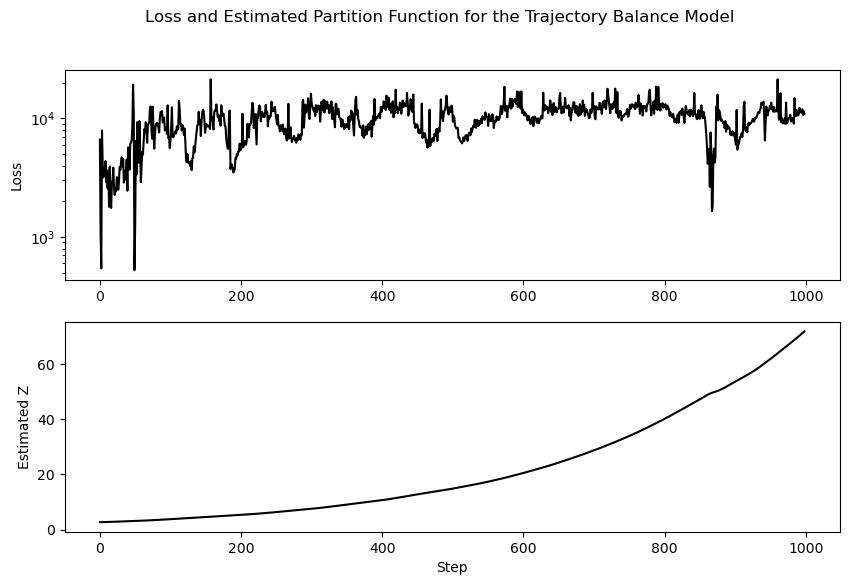

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(ax[0])
plt.plot(losses, color="black")
plt.yscale('log')
plt.ylabel('Loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs), color="black")
plt.ylabel('Estimated Z');
plt.xlabel('Step')
plt.suptitle("Loss and Estimated Partition Function for the Trajectory Balance Model")

## Example expressions and their IC

In [ ]:
# Utils
def expr_sequence_to_string(expr: List[str]) -> str:
    string = ''
    stack = []
    for a in expr:
        if a in ['BEG', 'SEP']:
            continue
        elif a in FEATURES:
            stack.append(a)
        elif a in UNARY:
            operand = stack.pop()
            stack.append(a + '(' + operand + ')')
        elif a in BINARY:
            operand_2 = stack.pop()
            operand_1 = stack.pop()
            stack.append(a + '(' + operand_1 + ',' + operand_2 + ')')
        else:
            ValueError
    return stack[0]

In [ ]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.html.use_mathjax', False)
res = pd.DataFrame(
    {'expr': [expr_sequence_to_string(ex) for ex in sampled_expressions], 'ic': sampled_ics}
).sort_values(by='ic')
res

,expr,ic
14738,"ops_divide(ops_abs(ops_multiply(ops_add(ops_log(ops_divide(ops_subtract(ops_divide(ops_add(ops_abs($open),$close),$open),ops_log($open)),$high)),$volume),$close)),$low)",-0.099250
16255,"ops_add(ops_multiply(ops_log(ops_multiply(ops_log(ops_divide(ops_log($volume),ops_abs($low))),$high)),$low),ops_abs($volume))",-0.079674
9617,"ops_multiply(ops_divide(ops_multiply(ops_divide(ops_log(ops_multiply($high,$volume)),$low),ops_abs($low)),$high),$close)",-0.059864
2423,"ops_multiply(ops_multiply(ops_abs(ops_multiply(ops_multiply($low,$low),ops_roll_std($volume))),$volume),$volume)",-0.059466
15691,"ops_log(ops_multiply(ops_multiply(ops_add(ops_multiply(ops_subtract(ops_multiply(ops_log(ops_add($volume,$high)),$high),$low),$high),$volume),$volume),$close))",-0.059436
...,...,...
12424,"ops_abs(ops_divide(ops_divide(ops_log(ops_add(ops_add(ops_log($low),ops_log($low)),ops_abs($low))),ops_abs($volume)),ops_abs($close)))",0.059323
11324,"ops_log(ops_divide(ops_divide(ops_divide(ops_multiply(ops_add($high,$high),ops_log(ops_abs($close))),$close),$volume),$close))",0.059380
7411,"ops_log(ops_multiply(ops_divide(ops_divide(ops_divide(ops_subtract(ops_add($open,$high),$close),$low),$close),ops_abs($volume)),ops_log($low)))",0.059535
1121,"ops_multiply(ops_multiply(ops_log(ops_divide(ops_subtract(ops_log(ops_multiply(ops_add(ops_divide(ops_multiply($low,$volume),$open),$volume),$volume)),$open),$volume)),$volume),$volume)",0.067524


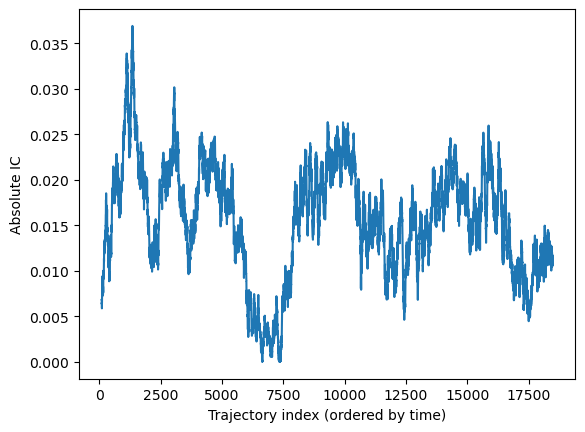

In [ ]:
# Reset index to create a new column with original index values
res['original_index'] = res.index
res0 = res.sort_values(by='original_index')
ic_ma = res0['ic'].rolling(window=100).mean()
plt.plot(range(len(ic_ma)), np.abs(ic_ma), label='Line')
plt.xlabel('Trajectory index (ordered by time)')
plt.ylabel('Absolute IC')
plt.show()

array([[<Axes: title={'center': 'ic'}>]], dtype=object)

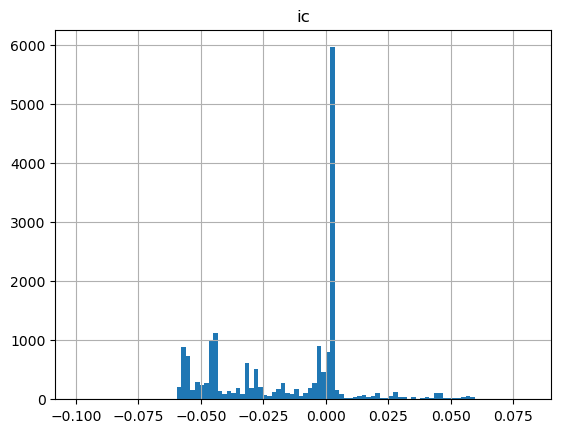

In [ ]:
res.hist('ic', bins=100)

## Zooming-in: groups of expressions with high absolute ICs 

From the following frequency plots, we may observe that: 
 - In all groups, \\$volume is a dominating action that drives high absolute IC.
 - `ops_multiply` occurs frequently in groups with |IC| > 0.05, compared to 0.04 < |IC| <= 0.05.
 - `ops_roll_std` occurs frequently in all groups.
 - `ops_log` and `ops_divide` occurs rarely, probably because it renders missingness with large chance.
 - `ops_subtract` ranks high in frequency for group with positive ICs, which makes sense because it flips the sign of `$volume`.
 - None of the groups used `ops_roll_corr`.

In [ ]:
## Negative IC
# IC < -0.05
expr_g1 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic < -0.05]
act_g1  = [a for expr in expr_g1 for a in expr]
# -0.05 <= IC< -0.04
expr_g2 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= -0.05 and ic < -0.04 for a in sampled_expressions[i]]
act_g2  = [a for expr in expr_g2 for a in expr]

## Positive IC
# IC >= 0.05
expr_g3 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= 0.05 for a in sampled_expressions[i]]
act_g3  = [a for expr in expr_g3 for a in expr]
# 0.04 <= IC< 0.05
expr_g4 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= 0.04 and ic < 0.05 for a in sampled_expressions[i]]
act_g4  = [a for expr in expr_g4 for a in expr]

In [ ]:
from collections import Counter
count_g1 = Counter(act_g1).most_common()
count_g2 = Counter(act_g2).most_common()
count_g3 = Counter(act_g3).most_common()
count_g4 = Counter(act_g4).most_common()

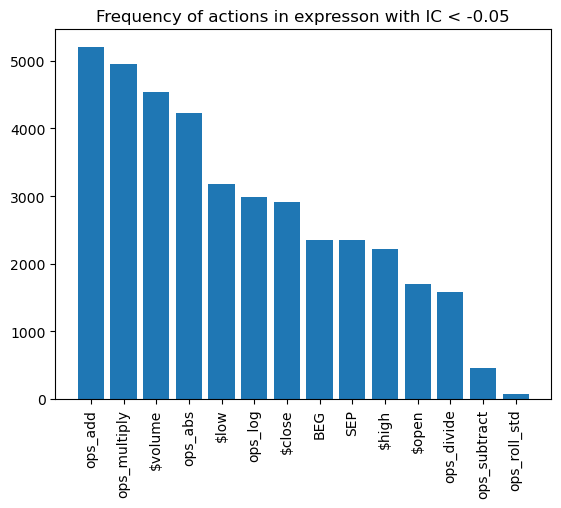

In [ ]:
labels, counts = zip(*count_g1)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with IC < -0.05')
plt.show()

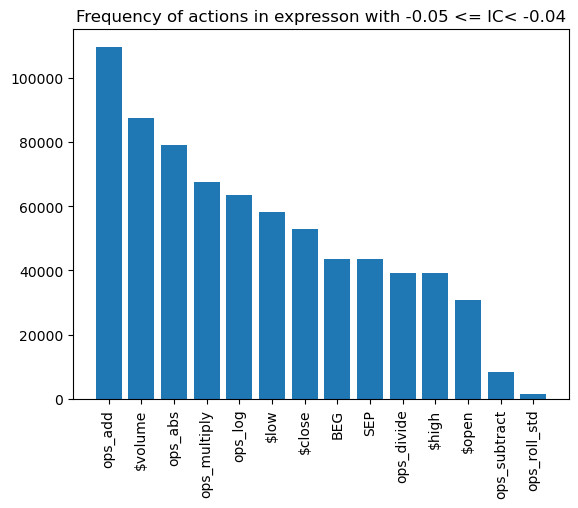

In [ ]:
labels, counts = zip(*count_g2)
plt.title('Frequency of actions in expresson with -0.05 <= IC< -0.04')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

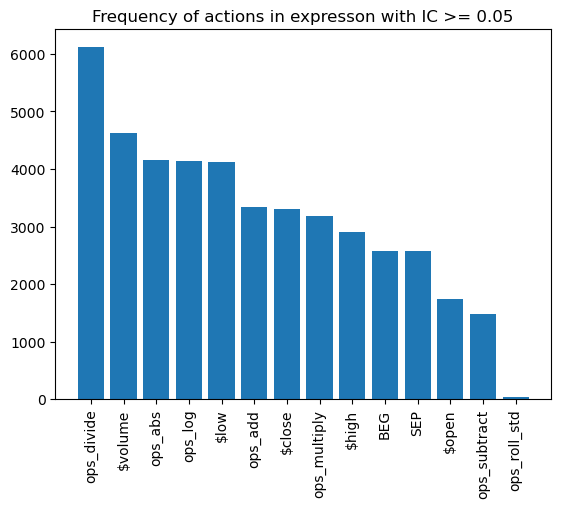

In [ ]:
labels, counts = zip(*count_g3)
plt.title('Frequency of actions in expresson with IC >= 0.05')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

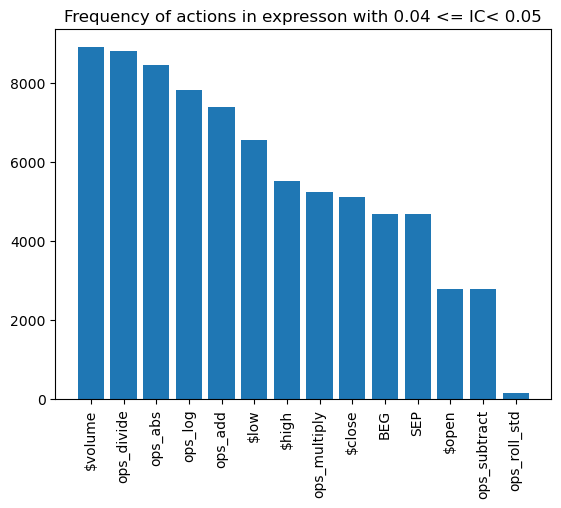

In [ ]:
labels, counts = zip(*count_g4)
plt.title('Frequency of actions in expresson with 0.04 <= IC< 0.05')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

## Zooming-in: Groups of expressions with low absolute ICs 

From the frequency plots, we may observe that: 
 - No distinctive dominating actions.
 - The rank seems to be at random based on multiple times of running the optimization.

In [ ]:
# |IC| < 0.01
expr_g5 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if np.abs(ic) < 0.01]
act_g5  = [a for expr in expr_g5 for a in expr]

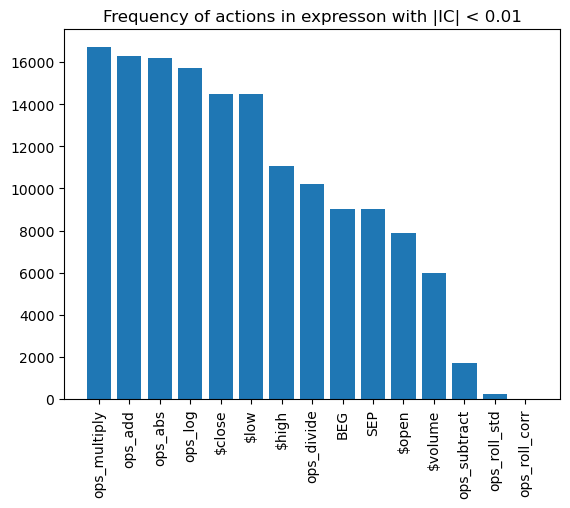

In [ ]:
count_g5 = Counter(act_g5).most_common()
labels, counts = zip(*count_g5)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with |IC| < 0.01')
plt.show()